<a href="https://colab.research.google.com/github/su2708/Group_8/blob/choi_sun1/movie_review1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
# 데이터셋 불러오기
df = pd.read_csv("netflix_reviews.csv")

# 데이터셋 크기와 열 정보 출력
print(f"Shape of the dataset: {df.shape}")
print(f"Columns in the dataset: {df.columns}")

Shape of the dataset: (116931, 8)
Columns in the dataset: Index(['reviewId', 'userName', 'content', 'score', 'thumbsUpCount',
       'reviewCreatedVersion', 'at', 'appVersion'],
      dtype='object')


In [2]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 전처리 함수
def preprocess_text(text):
    if isinstance(text, float):
        return ""
    text = text.lower()  # 대문자를 소문자로
    text = re.sub(r'[^\w\s]', '', text)  # 구두점 제거
    text = re.sub(r'\d+', '', text)  # 숫자 제거
    text = text.strip()  # 띄어쓰기 제외하고 빈 칸 제거
    return text

# 불필요한 열 제거
df = df[['content', 'score']]

# 리뷰 텍스트 정제
df['content'] = df['content'].apply(preprocess_text)

# 평점을 이진 레이블로 변환 (예: 3점 이상은 긍정, 그 외는 부정)
df['sentiment'] = df['score'].apply(lambda x: 1 if x >= 3 else 0)

# 전처리된 데이터 확인
print(df.head())


                                             content  score  sentiment
0                                          cant open      1          0
1                                       the best app      5          1
2  most of the famous korean drama are not dubbed...      2          0
3  its superb but can you please add comments sec...      5          1
4  the only reason i didnt give it four stars is ...      1          0


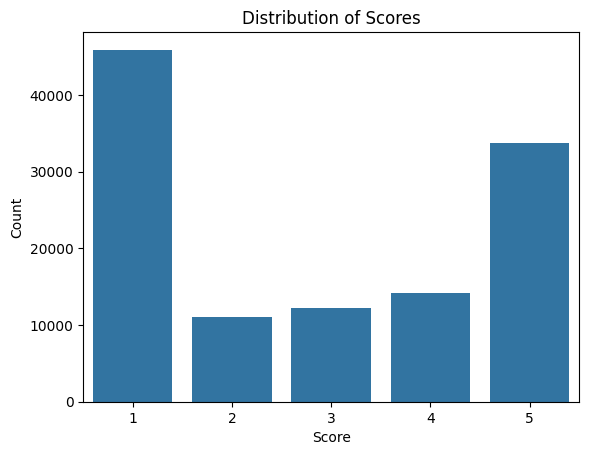

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# 리뷰 점수 분포 확인
sns.countplot(x='score', data=df)
plt.xlabel('Score')
plt.ylabel('Count')
plt.title('Distribution of Scores')
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import numpy as np
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
class TextPipeline:
    def __init__(self):
        self.vocab = {}

    def fit(self, texts):
        word_counts = Counter()
        for text in texts:
            words = word_tokenize(text)
            word_counts.update(words)
        self.vocab = {word: idx for idx, (word, _) in enumerate(word_counts.items(), 1)}  # 1부터 시작

    def __call__(self, text):
        words = word_tokenize(text)
        return [self.vocab.get(word, 0) for word in words]  # 사전에 없는 단어는 0으로 처리

In [6]:
class LabelPipeline:
    def __init__(self):
        self.label_encoder = LabelEncoder()

    def fit(self, labels):
        self.label_encoder.fit(labels)

    def __call__(self, label):
        return self.label_encoder.transform([label])[0]

In [7]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, ratings, text_pipeline, label_pipeline):
        self.reviews = reviews
        self.ratings = ratings
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.text_pipeline(self.reviews[idx])
        rating = self.label_pipeline(self.ratings[idx])
        return torch.tensor(review, dtype=torch.long), torch.tensor(rating, dtype=torch.long)

In [8]:
# 'content' 열이 문자열 형식인지 확인하고 변환
df['content'] = df['content'].astype(str)

In [9]:
print(df.columns)

Index(['content', 'score', 'sentiment'], dtype='object')


In [10]:
# 텍스트 파이프라인 인스턴스 생성 및 학습
text_pipeline = TextPipeline()
text_pipeline.fit(df['content'].values)

# 레이블 파이프라인 인스턴스 생성 및 학습
label_pipeline = LabelPipeline()
label_pipeline.fit(df['score'].values)

# 훈련 및 테스트 데이터를 설정
train_reviews = df['content'][:800].values  # 첫 800개는 훈련 데이터로
train_ratings = df['score'][:800].values
test_reviews = df['content'][800:].values   # 나머지는 테스트 데이터로
test_ratings = df['score'][800:].values

# 데이터셋 생성
train_dataset = ReviewDataset(train_reviews, train_ratings, text_pipeline, label_pipeline)
test_dataset = ReviewDataset(test_reviews, test_ratings, text_pipeline, label_pipeline)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [11]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        embeds = self.embedding(x)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc(lstm_out[:, -1, :])  # 마지막 타임스텝 출력
        return out


In [12]:
def train(model, loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for reviews, labels in loader:
            optimizer.zero_grad()
            outputs = model(reviews)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.4f}')

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for reviews, labels in loader:
            outputs = model(reviews)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [13]:
pip install transformers

In [14]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
import os
os.environ["WANDB_DISABLED"] = "true"

# 데이터셋 클래스 정의
class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# 데이터셋 생성
max_length = 128
train_dataset = MovieReviewDataset(train_df['content'].values, train_df['sentiment'].values, tokenizer, max_length)
test_dataset = MovieReviewDataset(test_df['content'].values, test_df['sentiment'].values, tokenizer, max_length)

# 모델 준비
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(df['sentiment'])))

# 트레이너 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# 모델 학습
trainer.train()

# 평가
trainer.evaluate()

In [16]:
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os

# 환경 설정
os.environ["WANDB_DISABLED"] = "true"

# 데이터셋 분리
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# 토크나이저 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# 데이터셋 클래스 정의
class MovieReviewDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
        }

# 데이터셋 생성
max_length = 128
train_dataset = MovieReviewDataset(train_df['content'].values, train_df['sentiment'].values, tokenizer, max_length)
test_dataset = MovieReviewDataset(test_df['content'].values, test_df['sentiment'].values, tokenizer, max_length)

# 모델 준비
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(df['sentiment'])))

# 평가를 위한 함수 정의
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)  # 예측값 중 가장 높은 점수를 가진 클래스로 선택
    acc = accuracy_score(labels, preds)  # 정확도 계산
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')  # 정밀도, 재현율, F1 점수
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# 트레이너 설정
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics  # 평가 지표 추가
)

# 모델 학습
trainer.train()

# 평가
eval_result = trainer.evaluate()

# 평가 결과 출력
print(f"Evaluation Results: {eval_result}")

# 정확도만 따로 출력
accuracy = eval_result['eval_accuracy']
print(f"Accuracy: {accuracy}")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. U

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.275800,0.331494,0.863343,0.866894,0.863343,0.863214
2,0.250800,0.359228,0.860264,0.860303,0.860264,0.860223
3,0.337800,0.393436,0.864668,0.866947,0.864668,0.864617
4,0.222200,0.543640,0.855946,0.856320,0.855946,0.855971
5,0.150100,0.667738,0.848762,0.848786,0.848762,0.848770


Evaluation Results: {'eval_loss': 0.6677379012107849, 'eval_accuracy': 0.8487621328088254, 'eval_precision': 0.8487864630963898, 'eval_recall': 0.8487621328088254, 'eval_f1': 0.8487702605093184, 'eval_runtime': 170.5382, 'eval_samples_per_second': 137.136, 'eval_steps_per_second': 8.573, 'epoch': 5.0}
Accuracy: 0.8487621328088254
